# 1. Preparación de datos

## Importar librerías

In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
#import sys

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

## Conexiones

In [2]:
# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargar datos

In [3]:
# Cargar bases de datos procesadas
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

In [4]:
# Ver las formas (número de imágenes, alto, ancho, canales, etc.)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5712, 198, 150, 3)
y_train shape: (5712, 1)
x_test shape: (1311, 198, 150, 3)
y_test shape: (1311, 1)


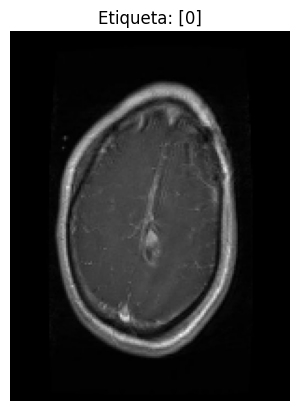

In [5]:
# Mostrar la imagen
plt.imshow(x_train[999])
plt.title(f"Etiqueta: {y_train[999]}")
plt.axis('off')
plt.show()

## Preparación de datos

In [6]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [7]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [8]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 198, 150, 3)
Shape x_test: (1311, 198, 150, 3)


In [9]:
# Convertir a 1D
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)

x_train2.shape
x_test2.shape

x_train2[1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [13]:
# Reconstruir la forma original (151 alto, 150 ancho, 3 canales)
img = x_train2[0].reshape((151, 150, 3))

# Mostrar la imagen
plt.imshow(img)
plt.title(f"Etiqueta: {int(y_train[1])}")
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 89100 into shape (151,150,3)

#2. Preprocesamiento  para modelos tradicionales

## Regresión Logística

In [ ]:
# Asegurar que las etiquetas tengan la forma correcta
y_train = y_train.ravel()
y_test = y_test.ravel()

# Entrenar el modelo
#lr = LogisticRegression(max_iter=100, solver='saga') # se queda corriendo :(
lr=LogisticRegression(max_iter=150)
lr.fit(x_train2, y_train)

# Predicciones en entrenamiento
pred_train_lr = lr.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_lr, zero_division=0))

# AUC en entrenamiento
probs_train_lr = lr.predict_proba(x_train2)
print("AUC train:", metrics.roc_auc_score(y_train, probs_train_lr, multi_class='ovr', average='macro'))

# Predicciones en test
pred_test_lr = lr.predict(x_test2)
print("Test:")
# Capturar el classification_report y almacenarlo
report_lr = metrics.classification_report(y_test, pred_test_lr, zero_division=0, output_dict=True)
print(metrics.classification_report(y_test, pred_test_lr, zero_division=0))

# Almacenar accuracy y AUC en variables
lr_accuracy_test = report_lr['accuracy']
probs_test_lr = lr.predict_proba(x_test2)
lr_auc_test = metrics.roc_auc_score(y_test, probs_test_lr, multi_class='ovr', average='macro')

print("AUC test:", lr_auc_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

AUC train: 1.0
Test:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       300
           1       0.77      0.80      0.78       306
           2       0.93      0.95      0.94       300
           3       0.97      0.99      0.98       405

    accuracy                           0.88      1311
   macro avg       0.88      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311

AUC test: 0.968377754747473


## Random Forest

In [ ]:
# Entrenar el modelo
rf = RandomForestClassifier()
rf.fit(x_train2, y_train.ravel())

# Entrenamos el modelo Random Forest utilizando los datos de entrenamiento.
# Se usa .ravel() para convertir y_train de un arreglo de 2 dimensiones (n,1) a 1 dimensión (n,)
# ya que RandomForestClassifier espera un vector unidimensional como etiquetas.


# Predicciones para train
pred_train = rf.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))

# Probabilidades para train (todas las clases)
pred_train_proba = rf.predict_proba(x_train2)
roc_auc_train = metrics.roc_auc_score(y_train, pred_train_proba, multi_class='ovr')
print("ROC AUC train:", roc_auc_train)

# Predicciones para test
pred_test = rf.predict(x_test2)
# Capturar el classification_report y almacenarlo
report_rf = metrics.classification_report(y_test, pred_test, output_dict=True)
print(metrics.classification_report(y_test, pred_test))

# Almacenar accuracy y AUC en variables
rf_accuracy_test = report_rf['accuracy']
pred_test_proba = rf.predict_proba(x_test2)
rf_auc_test = metrics.roc_auc_score(y_test, pred_test_proba, multi_class='ovr')

print("ROC AUC test:", rf_auc_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       300
           1       0.85      0.92      0.88       306
           2       0.95      0.97      0.96       300
           3       0.98      1.00      0.99       405

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311

ROC AUC test: 0.9916900232379317


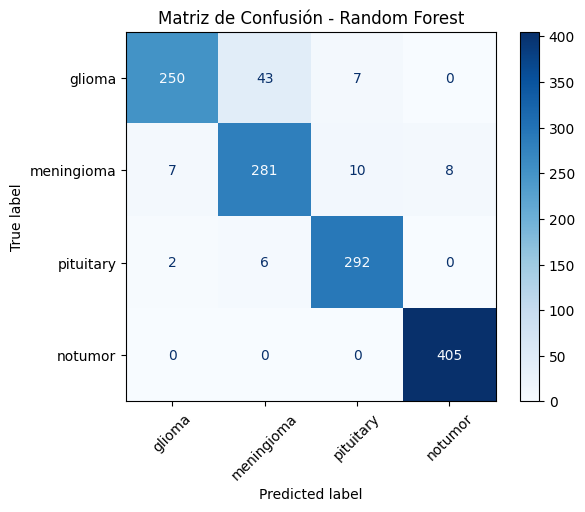

In [ ]:
# Obtener las predicciones sobre el conjunto de prueba
pred_test = rf.predict(x_test2)

# Definir las etiquetas de las clases
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión
cm = confusion_matrix(y_test, pred_test, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

## K Nearest Neighbor

In [ ]:
# Entrenar el modelo
knc = KNeighborsClassifier()
knc.fit(x_train2, y_train.ravel())

# Predicciones para entrenamiento
pred_train_knc = knc.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_knc))

# Probabilidades para train (todas las clases)
proba_train_knc = knc.predict_proba(x_train2)
roc_auc_train_knc = metrics.roc_auc_score(y_train, proba_train_knc, multi_class='ovr')
print("ROC AUC train:", roc_auc_train_knc)

# Predicciones para test
pred_test_knc = knc.predict(x_test2)
print("\nTest:")
# Capturar el classification_report y almacenarlo
report_knc = metrics.classification_report(y_test, pred_test_knc, output_dict=True)
print(metrics.classification_report(y_test, pred_test_knc))

# Almacenar accuracy y AUC en variables
knn_accuracy_test = report_knc['accuracy']
proba_test_knc = knc.predict_proba(x_test2)
knn_auc_test = metrics.roc_auc_score(y_test, proba_test_knc, multi_class='ovr')

print("ROC AUC test:", knn_auc_test)

Entrenamiento:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1321
           1       0.95      0.81      0.87      1339
           2       0.94      0.99      0.96      1457
           3       0.95      0.95      0.95      1595

    accuracy                           0.93      5712
   macro avg       0.93      0.92      0.92      5712
weighted avg       0.93      0.93      0.93      5712

ROC AUC train: 0.9946708915949678

Test:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       300
           1       0.90      0.53      0.67       306
           2       0.89      0.99      0.93       300
           3       0.88      0.94      0.91       405

    accuracy                           0.85      1311
   macro avg       0.86      0.85      0.84      1311
weighted avg       0.86      0.85      0.84      1311

ROC AUC test: 0.9796964856633543


## Decision Tree

In [ ]:
# Entrenar el modelo
clf_dt = DecisionTreeClassifier()
clf_dt.fit(x_train2, y_train)

# Predicciones para entrenamiento
pred_train_dt = clf_dt.predict(x_train2)
print("Entrenamiento:")
print(metrics.classification_report(y_train, pred_train_dt))

# Probabilidades para entrenamiento (todas las clases)
proba_train_dt = clf_dt.predict_proba(x_train2)
roc_auc_train_dt = metrics.roc_auc_score(y_train, proba_train_dt, multi_class='ovr')
print("ROC AUC train:", roc_auc_train_dt)

# Predicciones para test
pred_test_dt = clf_dt.predict(x_test2)
print("\nTest:")
# Capturar el classification_report y almacenarlo
report_dt = metrics.classification_report(y_test, pred_test_dt, output_dict=True)
print(metrics.classification_report(y_test, pred_test_dt))

# Probabilidades para test (todas las clases)
proba_test_dt = clf_dt.predict_proba(x_test2)
roc_auc_test_dt = metrics.roc_auc_score(y_test, proba_test_dt, multi_class='ovr')

# Almacenar accuracy y AUC en variables
dt_accuracy_test = report_dt['accuracy']
dt_auc_test = roc_auc_test_dt

print("ROC AUC test:", dt_auc_test)

Entrenamiento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0

Test:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       300
           1       0.78      0.81      0.79       306
           2       0.88      0.90      0.89       300
           3       0.96      0.98      0.97       405

    accuracy                           0.88      1311
   macro avg       0.87      0.87      0.87      1311
weighted avg       0.88      0.88      0.88      1311

ROC AUC test: 0.915919048592094


#3. Modelos de redes neuronales

## Redes Neuronales NN

### Clasificación Binaria

In [ ]:
#Crear modelo secuencial (capas apiladas)
fc_model_bi = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]), #Aplanar entrada
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa con 128 neuronas y ReLU
    tf.keras.layers.Dense(64, activation='relu'), # Capa densa con 64 neuronas y ReLU
    tf.keras.layers.Dense(1, activation='sigmoid') # Capa de salida (1 neurona), activación sigmoide para clasificación binaria
    ])

# Optimizador y funcion de perdida para el modelo
fc_model_bi.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Recall', 'Precision'] #Metricas a evaluar
    )

# entrenar el modelo con validacion
fc_model_bi.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 290ms/step - AUC: 0.4930 - Precision: 0.7680 - Recall: 0.9288 - accuracy: 0.2346 - loss: -1219.6835 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -13399.1592
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - AUC: 0.5000 - Precision: 0.7799 - Recall: 1.0000 - accuracy: 0.2476 - loss: -26911.8027 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -99025.8359
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - AUC: 0.5000 - Precision: 0.7660 - Recall: 1.0000 - accuracy: 0.2341 - loss: -143941.6875 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss: -353944.4688
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - AUC: 0.5000 - Precision: 0.7704 - Recall: 1.0000 - accuracy: 0.2350 - loss: -461703.7812 - val_AUC: 0.5000 - val_Precision: 0.7712 - val_Recall: 1.0000 - val_accuracy: 0.2334 - val_loss

### Clasificación multiclase

In [ ]:
# Etiquetas como enteros (0, 1, 2, ...)
y_train = np.array(y_train).astype('int32')
y_test = np.array(y_test).astype('int32')

# Cantidad de clases
num_classes = len(np.unique(y_train))

# Pesos de clase
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

# Modelo para multiclase
fc_model_multi = Sequential()
fc_model_multi.add(Flatten(input_shape=x_train.shape[1:]))
fc_model_multi.add(Dense(128, activation='relu'))
fc_model_multi.add(Dense(64, activation='relu'))
fc_model_multi.add(Dense(num_classes, activation='softmax'))  # salida multiclase

# Compilar modelo
fc_model_multi.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',  # <- multiclase
                 metrics=['accuracy'])

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
fc_model_multi.fit(x_train, y_train,
             batch_size=100,
             epochs=10,
             validation_data=(x_test, y_test),
             callbacks=[checkpoint],
             class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.4482 - loss: 2.8479
Epoch 1: val_accuracy improved from -inf to 0.72387, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 306ms/step - accuracy: 0.4499 - loss: 2.8287 - val_accuracy: 0.7239 - val_loss: 0.7622
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7224 - loss: 0.7352
Epoch 2: val_accuracy improved from 0.72387 to 0.74066, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.7226 - loss: 0.7346 - val_accuracy: 0.7407 - val_loss: 0.7064
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7970 - loss: 0.5807
Epoch 3: val_accuracy improved from 0.74066 to 0.77422, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step - accuracy: 0.7971 - loss: 0.5804 - val_accuracy: 0.7742 - val_loss: 0.5971
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8160 - loss: 0.5057
Epoch 4: val_accuracy improved from 0.77422 to 0.78032, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 239ms/step - accuracy: 0.8159 - loss: 0.5058 - val_accuracy: 0.7803 - val_loss: 0.6119
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8342 - loss: 0.4609
Epoch 5: val_accuracy improved from 0.78032 to 0.82456, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.8343 - loss: 0.4607 - val_accuracy: 0.8246 - val_loss: 0.4990
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8641 - loss: 0.3837
Epoch 6: val_accuracy did not improve from 0.82456
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 228ms/step - accuracy: 0.8639 - loss: 0.3843 - val_accuracy: 0.7872 - val_loss: 0.5746
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8794 - loss: 0.3537
Epoch 7: val_accuracy improved from 0.82456 to 0.84439, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.8795 - loss: 0.3536 - val_accuracy: 0.8444 - val_loss: 0.4294
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8994 - loss: 0.3109
Epoch 8: val_accuracy improved from 0.84439 to 0.85584, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.8994 - loss: 0.3107 - val_accuracy: 0.8558 - val_loss: 0.4252
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.9064 - loss: 0.2635
Epoch 9: val_accuracy did not improve from 0.85584
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.9064 - loss: 0.2637 - val_accuracy: 0.8551 - val_loss: 0.3891
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9153 - loss: 0.2561
Epoch 10: val_accuracy improved from 0.85584 to 0.86041, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.9152 - loss: 0.2563 - val_accuracy: 0.8604 - val_loss: 0.4319


In [ ]:
# Obtener las probabilidades de predicción para el modelo de red neuronal multiclase en el conjunto de prueba
# El modelo con activación softmax en la capa de salida ya produce probabilidades
y_pred_proba_nn_multi = fc_model_multi.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
# Usamos multi_class='ovr' y average='macro' para manejar clasificación multiclase
try:
    roc_auc_nn_multi = roc_auc_score(y_test, y_pred_proba_nn_multi, multi_class='ovr', average='macro')
    print(f"AUC para el modelo de red neuronal multiclase en el conjunto de prueba: {roc_auc_nn_multi:.4f}")
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo de red neuronal multiclase. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
AUC para el modelo de red neuronal multiclase en el conjunto de prueba: 0.9694


## Red neuronal convolucional NNC

In [ ]:
# Cantidad de clases
num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

cnn_model = Sequential()

# Primera capa convolucional y de pooling
# input_shape es solo para la primera capa
# Conv2D: 32 filtros, tamaño del filtro 3x3, activación ReLU
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
# MaxPooling2D: Ventana de pooling 2x2. Reduce la resolución a la mitad.
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional y de pooling
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar la salida de las capas convolucionales antes de las capas densas
cnn_model.add(Flatten())

# Capas densas (como en tu modelo anterior)
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# Capa de salida para clasificación multiclase (con softmax y num_classes)
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) # Añadir más métricas si deseamos, como AUC, Recall, Precision

# Mostrar un resumen de la arquitectura del modelo
cnn_model.summary()

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_cnn_modelo.keras", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
history = cnn_model.fit(x_train, y_train,
                        batch_size=100,
                        epochs=5,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Número de clases detectadas: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 149, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,644,868 (40.61 MB)

 Trainable params: 10,644,868 (40.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4681 - loss: 1.2133
Epoch 1: val_accuracy improved from -inf to 0.72464, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.4708 - loss: 1.2078 - val_accuracy: 0.7246 - val_loss: 0.7433
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8208 - loss: 0.4311
Epoch 2: val_accuracy improved from 0.72464 to 0.82838, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.8212 - loss: 0.4304 - val_accuracy: 0.8284 - val_loss: 0.4519
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9050 - loss: 0.2618
Epoch 3: val_accuracy improved from 0.82838 to 0.88863, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.9052 - loss: 0.2614 - val_accuracy: 0.8886 - val_loss: 0.3027
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9505 - loss: 0.1486
Epoch 4: val_accuracy improved from 0.8886

In [ ]:
# Obtener las probabilidades de predicción para el modelo CNN en el conjunto de prueba
# El modelo CNN con activación softmax en la capa de salida ya produce probabilidades
y_pred_proba_cnn = cnn_model.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
# Usamos multi_class='ovr' y average='macro' para manejar clasificación multiclase
try:
    roc_auc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr', average='macro')
    print(f"AUC para el modelo CNN en el conjunto de prueba: {roc_auc_cnn:.4f}")
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step
AUC para el modelo CNN en el conjunto de prueba: 0.9929


In [ ]:
checkpoint

### Evaluación del modelo de CNN

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss:.4f}")
print(f"Precisión en los datos de prueba: {accuracy:.4f}")
print(f"AUC en los datos de prueba: {roc_auc_cnn:.4f}")

Loss en los datos de prueba: 0.2489
Precisión en los datos de prueba: 0.9108
AUC en los datos de prueba: 0.9929


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 341ms/step


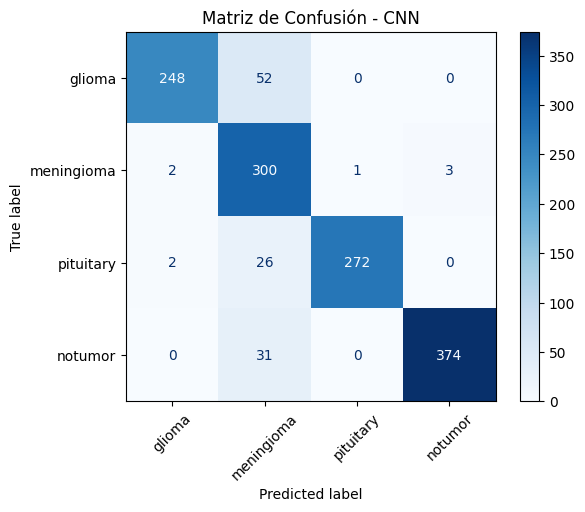

In [ ]:
# Obtener las predicciones del modelo CNN en el conjunto de prueba
y_pred_cnn = np.argmax(cnn_model.predict(x_test), axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión para el modelo CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_labels)
disp_cnn.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN")
plt.show()

### Comparación del los modelos evaluados

In [ ]:
# Recopilar métricas de rendimiento de las salidas anteriores

# Métricas de Red Neuronal Binaria
# Nota: Este modelo era binario, las métricas pueden no ser directamente comparables con los multiclase
nn_binary_accuracy_test = 0.2334 # Accuracy en el último epoch
nn_binary_auc_test = 0.5000 # AUC en el último epoch
nn_binary_loss_test = -15234488.0000 # Loss en el último epoch

# Métricas de Red Neuronal Multiclase
nn_multi_accuracy_test = 0.8604 # Accuracy en el último epoch
nn_multi_loss_test = 0.4319 # Loss en el último epoch

# Métricas de CNN (del output de la celda 6533a3cc y d57ae1d4)
cnn_accuracy_test = accuracy # Usamos la variable 'accuracy' del último cálculo
cnn_loss_test = loss # Usamos la variable 'loss' del último cálculo
cnn_auc_test = roc_auc_cnn # Usamos la variable 'roc_auc_cnn' del último cálculo


# Crear un DataFrame para comparar
data = {'Modelo': ['Regresión Logística', 'Random Forest', 'K-NN', 'Árbol de Decisión', 'Red Neuronal Binaria', 'Red Neuronal Multiclase', 'CNN'],
        'Accuracy (Test)': [lr_accuracy_test, rf_accuracy_test, knn_accuracy_test, dt_accuracy_test, nn_binary_accuracy_test, nn_multi_accuracy_test, cnn_accuracy_test],
        'AUC (Test)': [lr_auc_test, rf_auc_test, knn_auc_test, dt_auc_test, nn_binary_auc_test, roc_auc_nn_multi, cnn_auc_test],
        'Loss (Test)': ['N/A', 'N/A', 'N/A', 'N/A', nn_binary_loss_test, nn_multi_loss_test, cnn_loss_test]}

df_comparison = pd.DataFrame(data)

# Mostrar la tabla comparativa
print("Comparación de rendimiento de modelos en el conjunto de prueba:")
display(df_comparison)

Comparación de rendimiento de modelos en el conjunto de prueba:


,Modelo,Accuracy (Test),AUC (Test),Loss (Test)
0,Regresión Logística,0.883295,0.968378,N/A
1,Random Forest,0.936690,0.991690,N/A
2,K-NN,0.852784,0.979696,N/A
3,Árbol de Decisión,0.879481,0.915919,N/A
4,Red Neuronal Binaria,0.233400,0.500000,-15234488.0
5,Red Neuronal Multiclase,0.860400,0.969424,0.4319
6,CNN,0.910755,0.992859,0.248865
